## S2 Geometry

### Installation

General information can be found on the official website: http://s2geometry.io/

**Step 1.** Try installing and using `s2_py` library with `pip install s2-py`. If this fails, proceed to step #2

**Step 2.**  Follow instructions on the original GitHub repo to install the library: https://github.com/google/s2geometry

**Step 3.**  Now you should be able to install s2_py with `pip install s2-py`

**Step 4.** Optional: Source code is here: https://github.com/google/s2geometry/tree/master/src/s2. It's useful if you need to do something with S2 cells that is not in this tutorial. 

In [1]:
import s2_py as s2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, mapping

### Testing

#### Part 1. Create a cell from lat and long

Note: this will create a cell of the smallest possible level (30, which is less than a square inch). So far we are using S2 cell of level 14.

Here's reference table of all sizes: http://s2geometry.io/resources/s2cell_statistics.html

In [2]:
latlng = s2.S2LatLng.FromDegrees(-30.043800, -51.140220)
cell = s2.S2CellId(latlng)
cell.level()

30

In [3]:
# S2 Cell Id will be our main key
cell.id()

10743750136202470315

In [4]:
# We can look up parent S2 Cell ids up to the biggest cell
cell.parent().id()

10743750136202470316

In [5]:
parent = cell.parent().parent().parent().parent()
parent.level()

26

In [6]:
# We can check if higher level cell contains lower lower level cell
parent.contains(cell)

True

#### Part 2. Create S2 Cells from lat and long for a rectangle

In [7]:
# We need only two coordinates for rectangle
region_rect = s2.S2LatLngRect(
        s2.S2LatLng.FromDegrees(-51.264871, -30.241701),
        s2.S2LatLng.FromDegrees(-51.04618, -30.000003))

#### Part 3. Create S2 Cells from lat and long for a polygon

Most of our data will come in polygon format. For example, let's try with California.

Data source: https://www.census.gov/cgi-bin/geo/shapefiles/index.php

In [8]:
# Change the location to where you downloaded CA_State folder (it's also in EDA/Data folder on GitHub)
ca_df = gpd.read_file("./Data/CA_State/CA_State_TIGER2016.shp")
# we need to change coordinates system 
ca_df = ca_df.to_crs({'init': 'epsg:4326'})
ca_df

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,4,9,06,01779778,06,CA,California,00,G4000,A,403501101370,20466718403,+37.1551773,-119.5434183,(POLYGON ((-119.6347313537315 33.2654466936341...


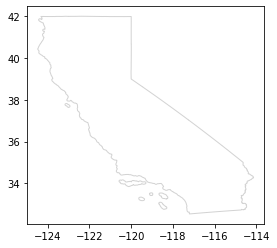

In [9]:
ca_df.plot(color='white', edgecolor='lightgrey')

All the key information is stored in `geometry`. We can explore it by using `mapping` function from `shapely` package. As we can see from the output below, our polygon is actually a multipolygon because of the islands, so there is a separate set of coordinates for all 7 "pieces" of land.

In [10]:
len(mapping(ca_df.geometry[0])['coordinates'])

7

In [11]:
def extract_max_polygon(fire_poly):
    """Return the largest polygon for each wildfire multipolygon"""
    fire_map = mapping(fire_poly)
    if 'coordinates' in fire_map:
        coords = fire_map['coordinates']
    elif 'features' in fire_map:
        coords = fire_map['features'][0]['geometry']['coordinates']
    
    max_poly = coords[0][0]
    for i in range(len(coords)):
        if len(coords[i][0]) > len(max_poly):
            max_poly = coords[i][0]
    return max_poly

In [12]:
# Now we can extract only the largest polygon to build S2 Cells.
ca_df['Largest_polygon'] = ca_df.geometry.apply(extract_max_polygon)
ca_df.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Largest_polygon
0,4,9,06,01779778,06,CA,California,00,G4000,A,403501101370,20466718403,+37.1551773,-119.5434183,(POLYGON ((-119.6347313537315 33.2654466936341...,"((-124.13657496576488, 41.46445707660226), (-1..."


In [13]:
def create_S2_loop(max_poly):
    """Converts Polygon into S2 Loop"""
    points = []
    for coord in tuple(reversed(max_poly)):
        long, lat = coord
        latlng = s2.S2LatLng.FromDegrees(lat, long)
        points.append(latlng.ToPoint())
    return s2.S2Loop(points)

In [14]:
# Now we can create an object called S2 loop based on that polygon's coordinates
ca_df['S2_Loop'] = ca_df.Largest_polygon.apply(create_S2_loop)
ca_df

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Largest_polygon,S2_Loop
0,4,9,06,01779778,06,CA,California,00,G4000,A,403501101370,20466718403,+37.1551773,-119.5434183,(POLYGON ((-119.6347313537315 33.2654466936341...,"((-124.13657496576488, 41.46445707660226), (-1...",<s2_py.pywraps2.S2Loop; proxy of <Swig Object ...


In [15]:
def create_S2_coverer(loop, lvl):
    """Generates a list of S2 Cells of specified level"""
    coverer = s2.S2RegionCoverer()
    coverer.set_min_level(lvl)
    coverer.set_max_level(lvl)
    return coverer.GetCovering(loop)

In [16]:
# Now let's generate all S2 cells of level 10 over the entire CA mainland
ca_df['S2_Cells'] = ca_df.S2_Loop.apply(create_S2_coverer, args=[10])
ca_df

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Largest_polygon,S2_Loop,S2_Cells
0,4,9,06,01779778,06,CA,California,00,G4000,A,403501101370,20466718403,+37.1551773,-119.5434183,(POLYGON ((-119.6347313537315 33.2654466936341...,"((-124.13657496576488, 41.46445707660226), (-1...",<s2_py.pywraps2.S2Loop; proxy of <Swig Object ...,"(2/2212102122 , 2/2212102123 , 2/2212102200 , ..."


In [17]:
def S2Cells_To_GPD(covering):
    geoms = []
    for cellid in covering:
        new_cell = s2.S2Cell(cellid)
        vertices = []
        for i in range(4):
            vertex = new_cell.GetVertex(i)
            latlng = s2.S2LatLng(vertex)
            vertices.append((latlng.lng().degrees(),
                             latlng.lat().degrees()))
        geo = Polygon(vertices)
        geoms.append(geo)
    return gpd.GeoDataFrame(crs={'init': 'epsg:4326'}, geometry=geoms) 

In [18]:
ca_s2_df = S2Cells_To_GPD(ca_df['S2_Cells'][0])
ca_s2_df.head()

,geometry
0,POLYGON ((-121.4677316834114 42.04232965429553...
1,POLYGON ((-121.3727682209074 42.07118272583848...
2,POLYGON ((-121.1142610115251 42.07239958691621...
3,POLYGON ((-121.0461208729064 42.01617736891059...
4,POLYGON ((-121.1410057347761 41.98772206109075...


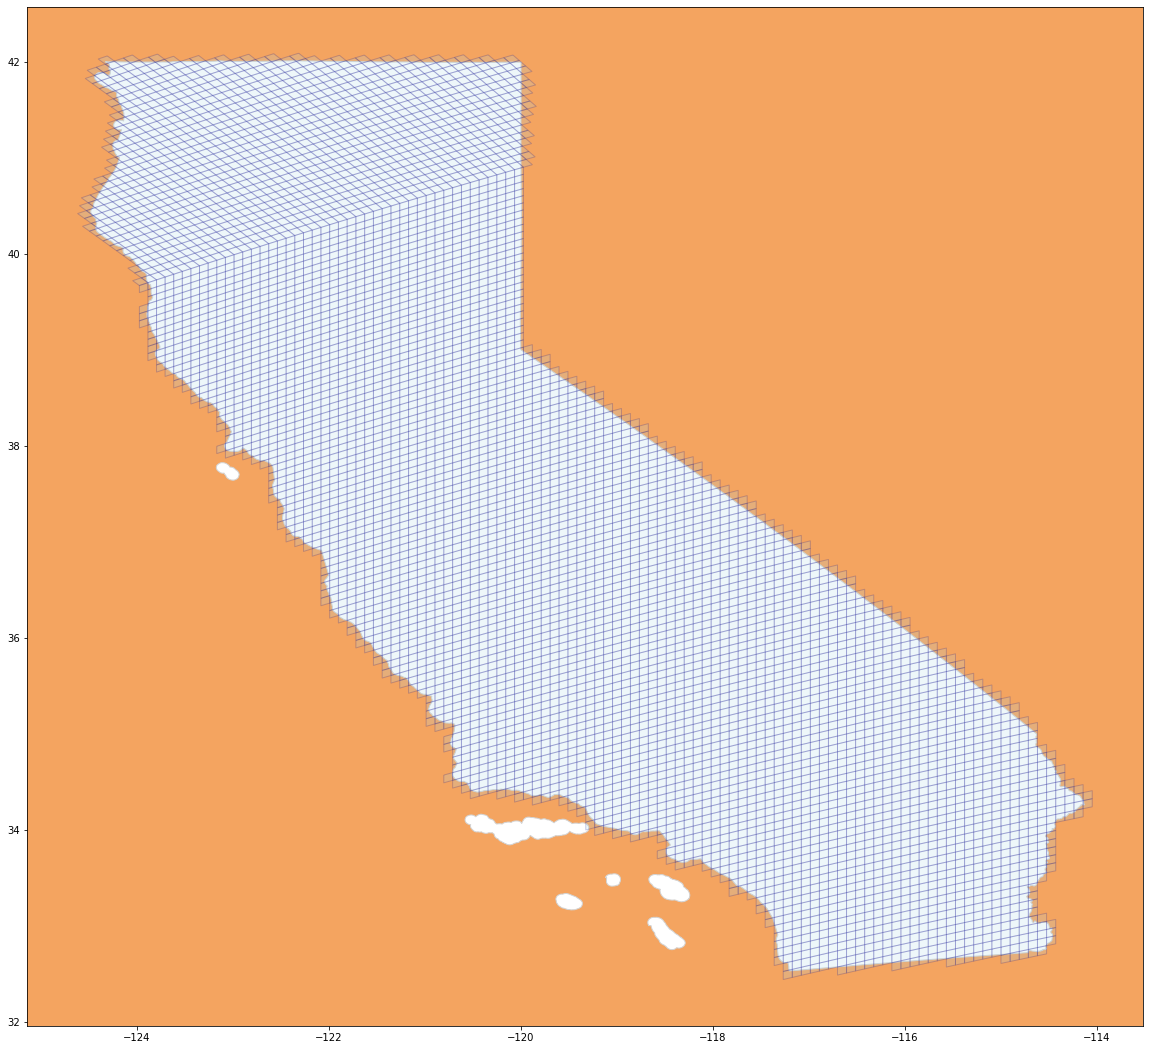

In [19]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor('sandybrown')
ca_df.plot(ax=ax, color='white', edgecolor='lightgrey')
ca_s2_df.plot(ax=ax, color='lightblue', edgecolor='darkblue', alpha=0.2)
plt.show()

#### Part 4. Creating final dataset with S2 Cell Id as a key

In [20]:
def split_data_frame_list(df, target_column, row_id):
    """
    Splits a column with lists into rows
    
    Arguments:
        df: dataframe
        target_column: name of column that contains lists        
        row_id: column to merge back on
    
    Returns:
        Dataframe
    """
    
    # create a new dataframe with each item in a seperate column, dropping rows with missing values
    col_df = pd.DataFrame(df[target_column].tolist())\
                .join(df[[target_column, row_id]])\
                .drop(columns=[target_column])\
                .set_index(row_id)

    # create a series with columns stacked as rows         
    stacked = col_df.stack()\
                    .reset_index()\
                    .drop(columns='level_1')
    stacked.columns = [row_id, target_column]

    return stacked

In [21]:
ca_s2_df = split_data_frame_list(ca_df, 'S2_Cells', 'NAME')
ca_s2_df['S2_Cells_ID'] = ca_s2_df.S2_Cells.apply(lambda x: x.ToToken())
ca_s2_df.shape

(6141, 3)

In [22]:
ca_s2_df.head()

,NAME,S2_Cells,S2_Cells_ID
0,California,2/2212102122 ,54c935
1,California,2/2212102123 ,54c937
2,California,2/2212102200 ,54c941
3,California,2/2212102201 ,54c943
4,California,2/2212102202 ,54c945


In [23]:
# Now we can merge all our data onto each S2 Cell and create final dataset
ca_s2_df = ca_s2_df[['NAME', 'S2_Cells_ID']].set_index('NAME').join(ca_df.set_index('NAME'), on='NAME', how='left').reset_index()
ca_s2_df.shape

(6141, 19)

In [24]:
ca_s2_df.head()

,NAME,S2_Cells_ID,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Largest_polygon,S2_Loop,S2_Cells
0,California,54c935,4,9,06,01779778,06,CA,00,G4000,A,403501101370,20466718403,+37.1551773,-119.5434183,(POLYGON ((-119.6347313537315 33.2654466936341...,"((-124.13657496576488, 41.46445707660226), (-1...",<s2_py.pywraps2.S2Loop; proxy of <Swig Object ...,"(2/2212102122 , 2/2212102123 , 2/2212102200 , ..."
1,California,54c937,4,9,06,01779778,06,CA,00,G4000,A,403501101370,20466718403,+37.1551773,-119.5434183,(POLYGON ((-119.6347313537315 33.2654466936341...,"((-124.13657496576488, 41.46445707660226), (-1...",<s2_py.pywraps2.S2Loop; proxy of <Swig Object ...,"(2/2212102122 , 2/2212102123 , 2/2212102200 , ..."
2,California,54c941,4,9,06,01779778,06,CA,00,G4000,A,403501101370,20466718403,+37.1551773,-119.5434183,(POLYGON ((-119.6347313537315 33.2654466936341...,"((-124.13657496576488, 41.46445707660226), (-1...",<s2_py.pywraps2.S2Loop; proxy of <Swig Object ...,"(2/2212102122 , 2/2212102123 , 2/2212102200 , ..."
3,California,54c943,4,9,06,01779778,06,CA,00,G4000,A,403501101370,20466718403,+37.1551773,-119.5434183,(POLYGON ((-119.6347313537315 33.2654466936341...,"((-124.13657496576488, 41.46445707660226), (-1...",<s2_py.pywraps2.S2Loop; proxy of <Swig Object ...,"(2/2212102122 , 2/2212102123 , 2/2212102200 , ..."
4,California,54c945,4,9,06,01779778,06,CA,00,G4000,A,403501101370,20466718403,+37.1551773,-119.5434183,(POLYGON ((-119.6347313537315 33.2654466936341...,"((-124.13657496576488, 41.46445707660226), (-1...",<s2_py.pywraps2.S2Loop; proxy of <Swig Object ...,"(2/2212102122 , 2/2212102123 , 2/2212102200 , ..."
